# A Look Into Attrition: What's the Real Reason?

* Motivation:

In this hypothetical scenario the head of the R&D department wants the data anlysts to understand why employees leave the company. The main concern of the head of R&D is that employees that perform well and have a solid amount of experience is the subset that is most likely to leave the company. The goal here is to use data provided of all the employees in the deparment and understand what makes an employee decide to leave.


* Resources:
        
        *Mock Dataset of HR measurements and Employee Statistics
        *Data Visualizations with ggplot
        *Correlations and Causations
        
* Methods:
        
        *Binning variables into subset of groups to understand the behavior of each subset of groups.
        *Analyze demographics and salary metrics.
        *Use classification models to understand variable importance in attrition.
        *Use correlation coefficients to understand which variables might me correlated.
        
* Objective:

Using the mock dataset, answer these 6 questions supported by data visualizations and exploratory analysis:           
1) Describe the categories of information that is collected, and how the data is reported (binary, continuous, categorical, etc).                               
2) Summarize the key metrics for the R&D division (e.g., total salary for R&D, number of employees, demographics, etc).                                  
3) Do the data support the assertion of the head of R&D (i.e. the relationship between experience and performance)?   
4) Identify at least one subset of employees who are at disproportionate risk for leaving based on the data provided.
5) What recommendations would you make to the head of R&D to address the risk factors for attrition that you identified in Q3?                           
6) For one of your recommendations, how would you design a rapid experiment to learn whether your recommendation successfully mitigates attrition? What other information would you want to track and how would you track and report it?              
   

In [20]:
#Pre-processing
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(data.table))
library(gridExtra)
library(Information)
library("rattle.data")
library(corrplot)
library(randomForest)
library(caret)
library(ggplot2)
library(repr)

# Change plot size to 4 x 3
options(repr.plot.width=20, repr.plot.height=20)

setwd("/Users/luislosada/Columbia Drive/Leading Change/Midterm")
data = fread("Assignment_2_data_set.csv",stringsAsFactors = T)

#### 1) Describe the Categories

In [2]:
str(data)

Classes ‘data.table’ and 'data.frame':	1470 obs. of  35 variables:
 $ Age                     : int  41 49 37 33 27 32 59 30 38 36 ...
 $ Attrition               : Factor w/ 2 levels "No","Yes": 2 1 2 1 1 1 1 1 1 1 ...
 $ BusinessTravel          : Factor w/ 3 levels "Non-Travel","Travel_Frequently",..: 3 2 3 2 3 2 3 3 2 3 ...
 $ DailyRate               : int  1102 279 1373 1392 591 1005 1324 1358 216 1299 ...
 $ Department              : Factor w/ 3 levels "Human Resources",..: 3 2 2 2 2 2 2 2 2 2 ...
 $ DistanceFromHome        : int  1 8 2 3 2 2 3 24 23 27 ...
 $ Education               : int  2 1 2 4 1 2 3 1 3 3 ...
 $ EducationField          : Factor w/ 6 levels "Human Resources",..: 2 2 5 2 4 2 4 2 2 4 ...
 $ EmployeeCount           : int  1 1 1 1 1 1 1 1 1 1 ...
 $ EmployeeNumber          : int  1 2 4 5 7 8 10 11 12 13 ...
 $ EnvironmentSatisfaction : int  2 3 4 4 1 4 3 4 4 3 ...
 $ Gender                  : Factor w/ 2 levels "Female","Male": 1 2 2 1 2 2 1 2 2 2 ...
 $ HourlyRate

In [3]:
summary(data)

      Age        Attrition            BusinessTravel   DailyRate     
 Min.   :18.00   No :1233   Non-Travel       : 150   Min.   : 102.0  
 1st Qu.:30.00   Yes: 237   Travel_Frequently: 277   1st Qu.: 465.0  
 Median :36.00              Travel_Rarely    :1043   Median : 802.0  
 Mean   :36.92                                       Mean   : 802.5  
 3rd Qu.:43.00                                       3rd Qu.:1157.0  
 Max.   :60.00                                       Max.   :1499.0  
                                                                     
                  Department  DistanceFromHome   Education    
 Human Resources       : 63   Min.   : 1.000   Min.   :1.000  
 Research & Development:961   1st Qu.: 2.000   1st Qu.:2.000  
 Sales                 :446   Median : 7.000   Median :3.000  
                              Mean   : 9.193   Mean   :2.913  
                              3rd Qu.:14.000   3rd Qu.:4.000  
                              Max.   :29.000   Max.   :5.000  

These tables show a brief overview of all the variables present in the dataset along with their type, a description and some quick stats. Here’s an explanation of the types:
-	All numerical values are integers (no decimals). 
-	Factors are nominal variables, meaning they are categorical values with a fixed amount of options for the values.
-	Factors can also be in an ordinal space. Survey type questions like job satisfaction or work-life balance provide a range of values that evaluate an employees behavior or feeling.
-	 Uid is the ID that represents that employee.

#### 2) Summarize the Key Metrics for the R&D division.

In [4]:
#Prepping the Data
DF_RandD = data[data$Department == 'Research & Development'] #subset of R&D employees

#Function creation for plot arrangement
plot_arrange<- function(main,indepent_variable){
  myplots <- vector('list', ncol(main))
  iv<-as.factor(main[,which(colnames(main) == indepent_variable)])
  for (i in 2:length(main)){
    myplots[[i]] <- local({
      i <- i
      name <- colnames(main)[i]
      x<-main[,name]
      p = ggplot(data = main, aes(x = x,group = as.factor(iv),fill=as.factor(iv)))+
        geom_bar(aes(y=..prop..), stat="count", position=position_dodge())+
        labs(x = paste(name), y = "Proportion", fill = "Gender")+
        scale_y_continuous(labels = scales::percent)+
        theme(axis.text.x = element_text(angle = 75,hjust = 1))
    })
  }
  myplots[sapply(myplots, is.null)] <- NULL
  n <- length(myplots)
  nCol <- floor(sqrt(n))
  do.call("grid.arrange", c(myplots, ncol=nCol))
}


###### Salary Metrics
First lets look at Salary Metrics for the R&D Department:

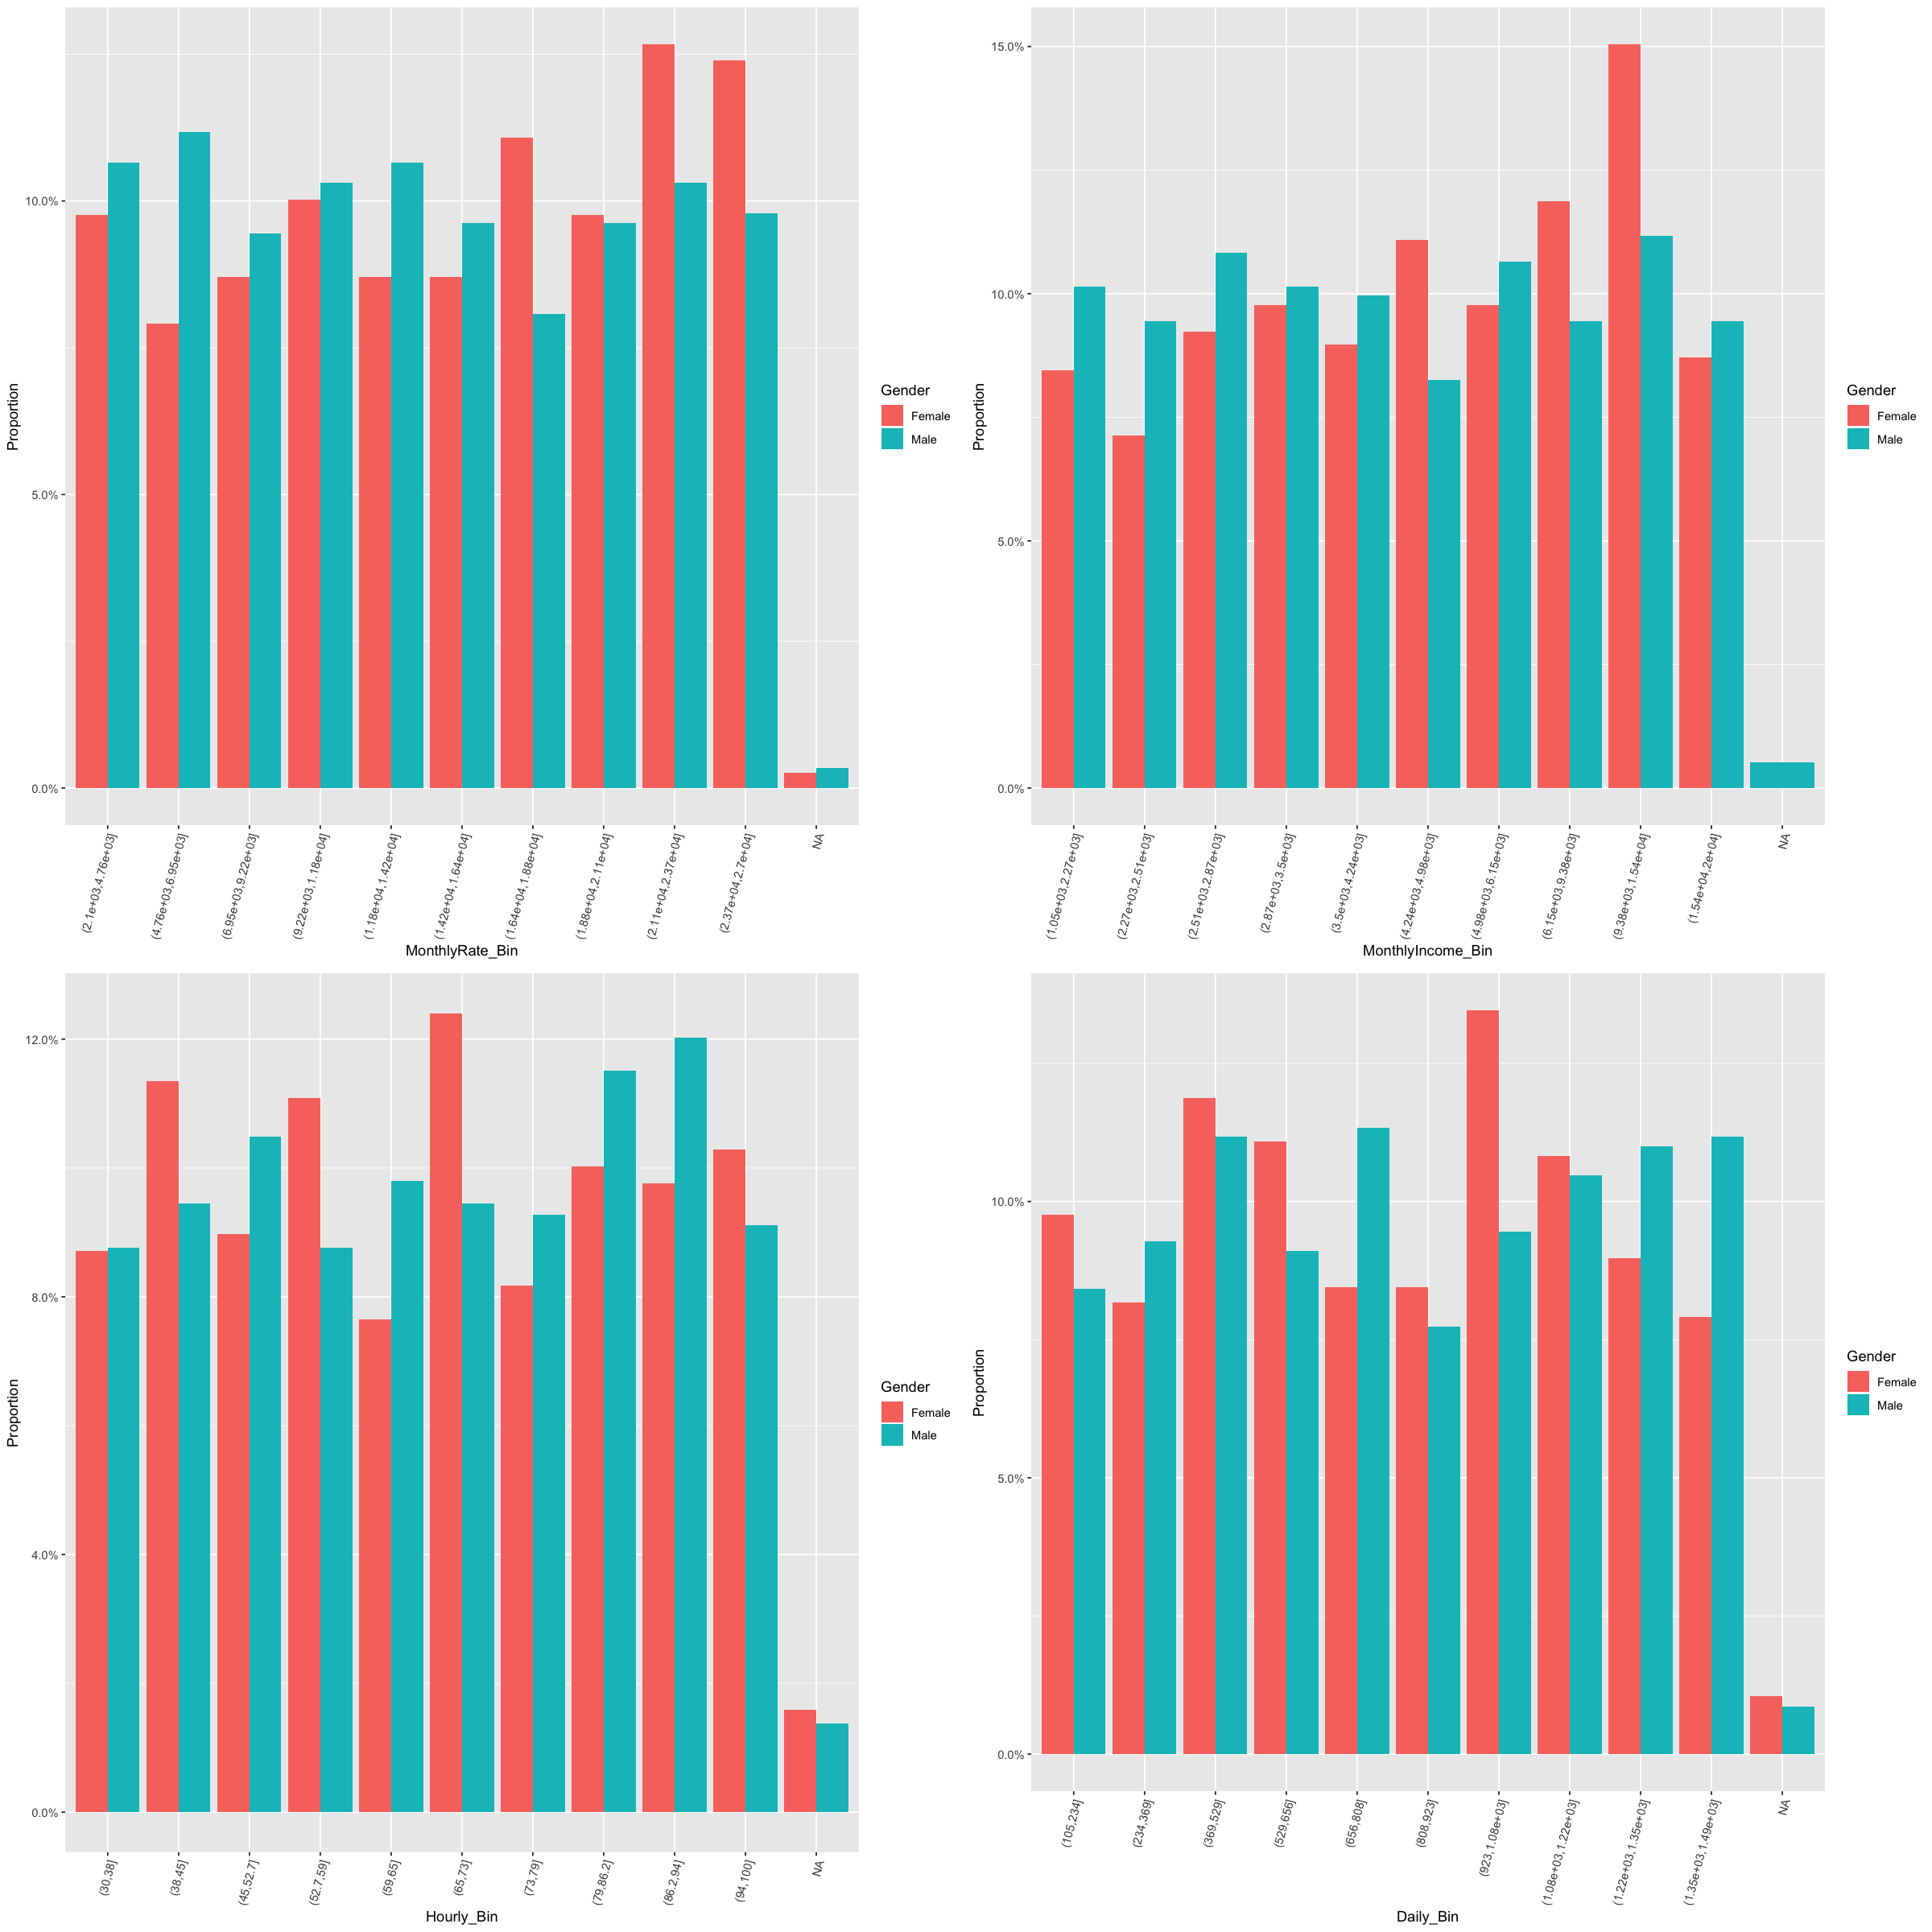

In [5]:
SalaryM_DF<-DF_RandD[,c('Gender','DailyRate','HourlyRate','MonthlyIncome','MonthlyRate')]

#Binning
Binning<- function(df){
set.seed(123)
spec = c(train = .5, test = .25, validate = .25)

g = sample(cut(
  seq(nrow(df)), 
  nrow(df)*cumsum(c(0,spec)),
  labels = names(spec)
))

df_list = split(df, g)

# Check the results:
sapply(df_list, nrow)/nrow(df)

train    = df_list$train
test     = df_list$test
validate = df_list$validate
return(train)
}
tt = Binning(SalaryM_DF)

#Add to the dataset
train.cut = quantile(tt$DailyRate, prob = seq(0, 1, 0.1))
Bin_Set <- SalaryM_DF %>% 
  mutate(DailyRate.equalSize = cut(DailyRate, breaks = train.cut)
  )
SalaryM_DF$Daily_Bin<-as.factor(Bin_Set$DailyRate.equalSize)

train.cut2 = quantile(tt$HourlyRate, prob = seq(0, 1, 0.1))
Bin_Set <- SalaryM_DF %>% 
  mutate(HourlyRate.equalSize = cut(HourlyRate, breaks = train.cut2)
  )
SalaryM_DF$Hourly_Bin<-as.factor(Bin_Set$HourlyRate.equalSize)

train.cut3 = quantile(tt$MonthlyIncome, prob = seq(0, 1, 0.1))
Bin_Set <- SalaryM_DF %>% 
  mutate(MonthlyIncome.equalSize = cut(MonthlyIncome, breaks = train.cut3)
  )
SalaryM_DF$MonthlyIncome_Bin<-as.factor(Bin_Set$MonthlyIncome.equalSize)

train.cut4 = quantile(tt$MonthlyRate, prob = seq(0, 1, 0.1))
Bin_Set <- SalaryM_DF %>% 
  mutate(MonthlyRate.equalSize = cut(MonthlyRate, breaks = train.cut4)
  )
SalaryM_DF$MonthlyRate_Bin<-as.factor(Bin_Set$MonthlyRate.equalSize)

#Finally Plotting
plot_arrange(as.data.frame(SalaryM_DF[,c('Gender',"MonthlyRate_Bin","MonthlyIncome_Bin",
                                         "Hourly_Bin","Daily_Bin")]),'Gender')


In [6]:
summary(SalaryM_DF)

    Gender      DailyRate        HourlyRate     MonthlyIncome    MonthlyRate   
 Female:379   Min.   : 102.0   Min.   : 30.00   Min.   : 1009   Min.   : 2094  
 Male  :582   1st Qu.: 469.0   1st Qu.: 49.00   1st Qu.: 2741   1st Qu.: 8007  
              Median : 810.0   Median : 66.00   Median : 4374   Median :14242  
              Mean   : 806.9   Mean   : 66.17   Mean   : 6281   Mean   :14285  
              3rd Qu.:1153.0   3rd Qu.: 84.00   3rd Qu.: 7655   3rd Qu.:20284  
              Max.   :1496.0   Max.   :100.00   Max.   :19999   Max.   :26999  
                                                                               
               Daily_Bin       Hourly_Bin            MonthlyIncome_Bin
 (369,529]          :110   (86.2,94]:107   (9.38e+03,1.54e+04]:122    
 (923,1.08e+03]     :106   (79,86.2]:105   (6.15e+03,9.38e+03]:100    
 (1.08e+03,1.22e+03]:102   (65,73]  :102   (4.98e+03,6.15e+03]: 99    
 (656,808]          : 98   (38,45]  : 98   (2.51e+03,2.87e+03]: 98    
 (1.2

These graphs show us that in the R&D department Female employees seem to have lower participation (379 females to 582 Males). However, a higher proportion of the female employees fall on the higher bins for Monthly Rate and Monthly Income categories. In contrast, the stats for the Hourly and Daily rates show that female employees trail in the higher tiers to men. This might mean that they are getting paid less by the hour but end up working more extra hours and therefore getting paid more.

###### Demographic Metrics
Now lets dive into the demographic variables in the set.

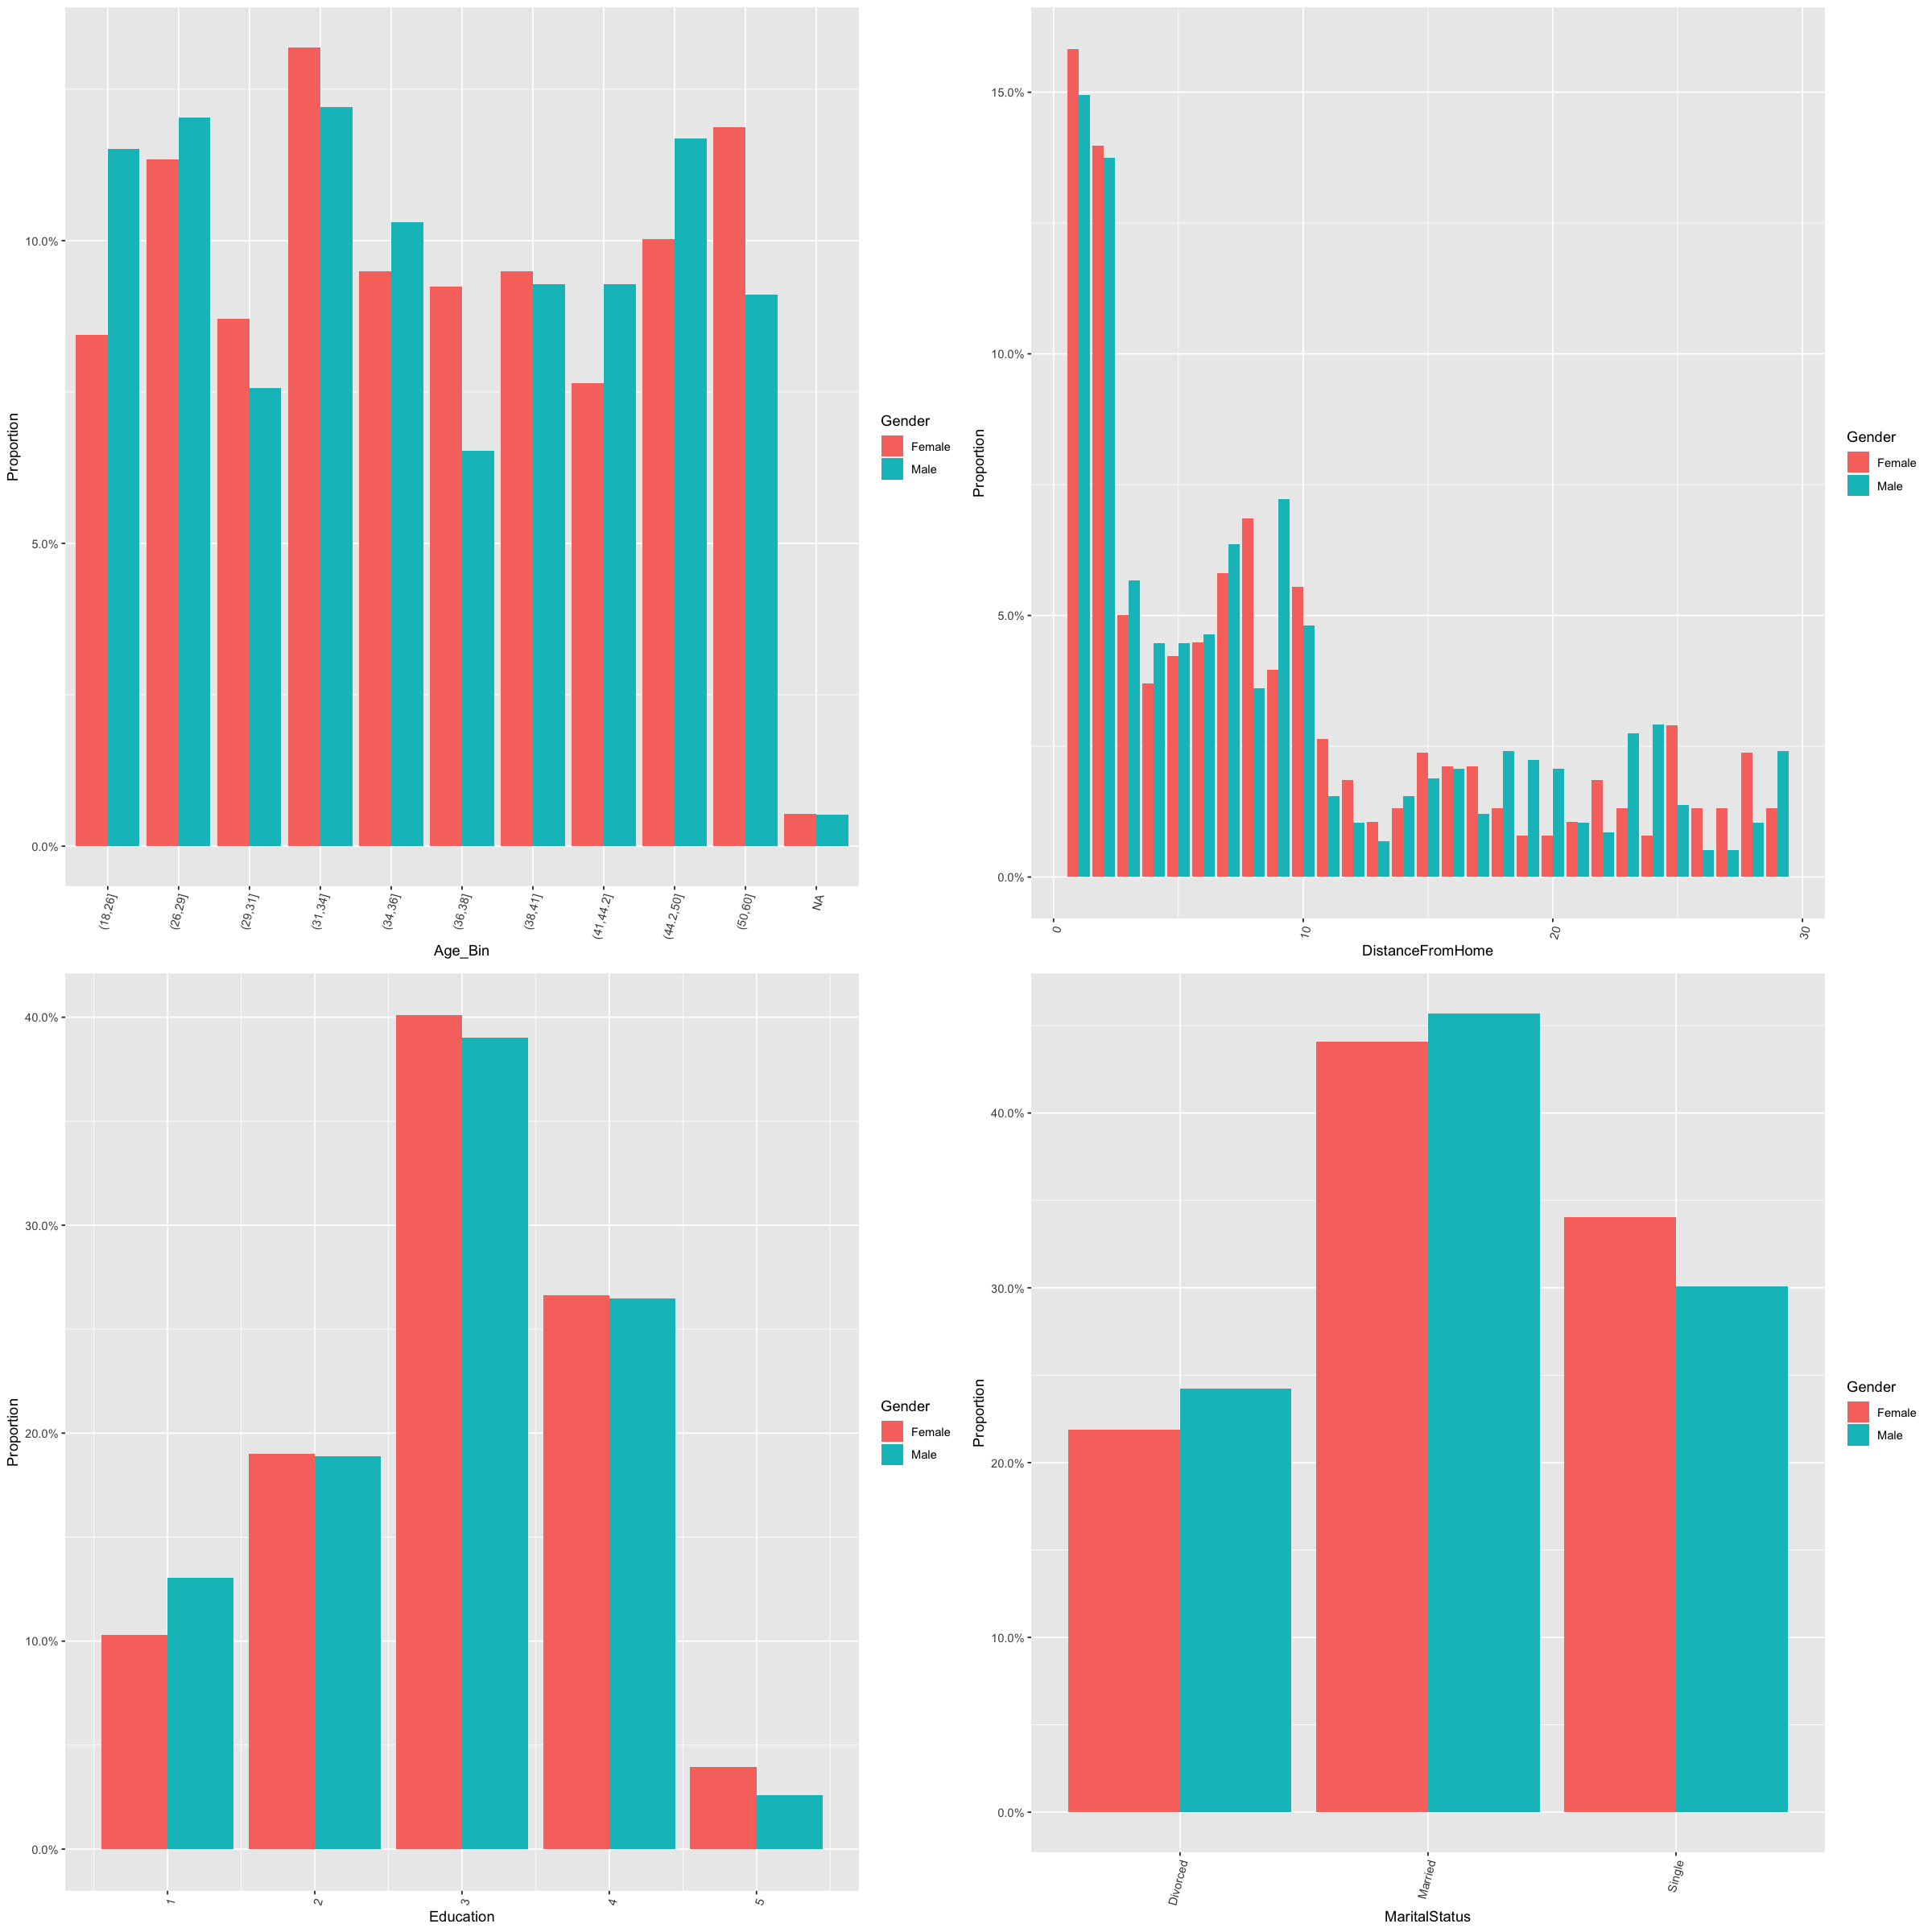

In [7]:
#Demographics

t2 = Binning(DF_RandD)

train.cut = quantile(t2$Age, prob = seq(0, 1, 0.1))
Bin_Set <- DF_RandD %>% 
  mutate(Age.equalSize = cut(Age, breaks = train.cut)
  )
DF_RandD$Age_Bin<-as.factor(Bin_Set$Age.equalSize)

plot_arrange(as.data.frame(DF_RandD[,c('Gender',"Age_Bin","DistanceFromHome","Education","MaritalStatus")]),'Gender')

In [8]:
summary(DF_RandD[,c('Gender',"Age","DistanceFromHome","Education","MaritalStatus")])

    Gender         Age        DistanceFromHome   Education      MaritalStatus
 Female:379   Min.   :18.00   Min.   : 1.000   Min.   :1.000   Divorced:224  
 Male  :582   1st Qu.:30.00   1st Qu.: 2.000   1st Qu.:2.000   Married :433  
              Median :36.00   Median : 7.000   Median :3.000   Single  :304  
              Mean   :37.04   Mean   : 9.145   Mean   :2.899                 
              3rd Qu.:43.00   3rd Qu.:14.000   3rd Qu.:4.000                 
              Max.   :60.00   Max.   :29.000   Max.   :5.000                 

The data shows us that:
-	Woman employeed in the R&D department tend to live closer to work than men.
-	Young men tend to be highered more than young women.
-	A higher proportion of all the woman in the company are in the 50,60 range. This could mean that women stay for longer periods of time than men do in the company.
-	Education and marriage status seem pretty even between both groups.


#### 3) Exploring the concerns of the head of R&D

In [9]:
#Head of HR Concerns
train.cut5 = quantile(t2$YearsAtCompany, prob = seq(0, 1, 0.1))
Bin_Set <- DF_RandD %>% 
  mutate(YearstAtCompany.equalSize = cut(YearsAtCompany, breaks = train.cut5)
  )
DF_RandD$Yrs_Comp_Bin<-as.factor(Bin_Set$YearstAtCompany.equalSize)

summary(DF_RandD)

      Age        Attrition           BusinessTravel   DailyRate     
 Min.   :18.00   No :828   Non-Travel       : 97    Min.   : 102.0  
 1st Qu.:30.00   Yes:133   Travel_Frequently:182    1st Qu.: 469.0  
 Median :36.00             Travel_Rarely    :682    Median : 810.0  
 Mean   :37.04                                      Mean   : 806.9  
 3rd Qu.:43.00                                      3rd Qu.:1153.0  
 Max.   :60.00                                      Max.   :1496.0  
                                                                    
                  Department  DistanceFromHome   Education    
 Human Resources       :  0   Min.   : 1.000   Min.   :1.000  
 Research & Development:961   1st Qu.: 2.000   1st Qu.:2.000  
 Sales                 :  0   Median : 7.000   Median :3.000  
                              Mean   : 9.145   Mean   :2.899  
                              3rd Qu.:14.000   3rd Qu.:4.000  
                              Max.   :29.000   Max.   :5.000  
       

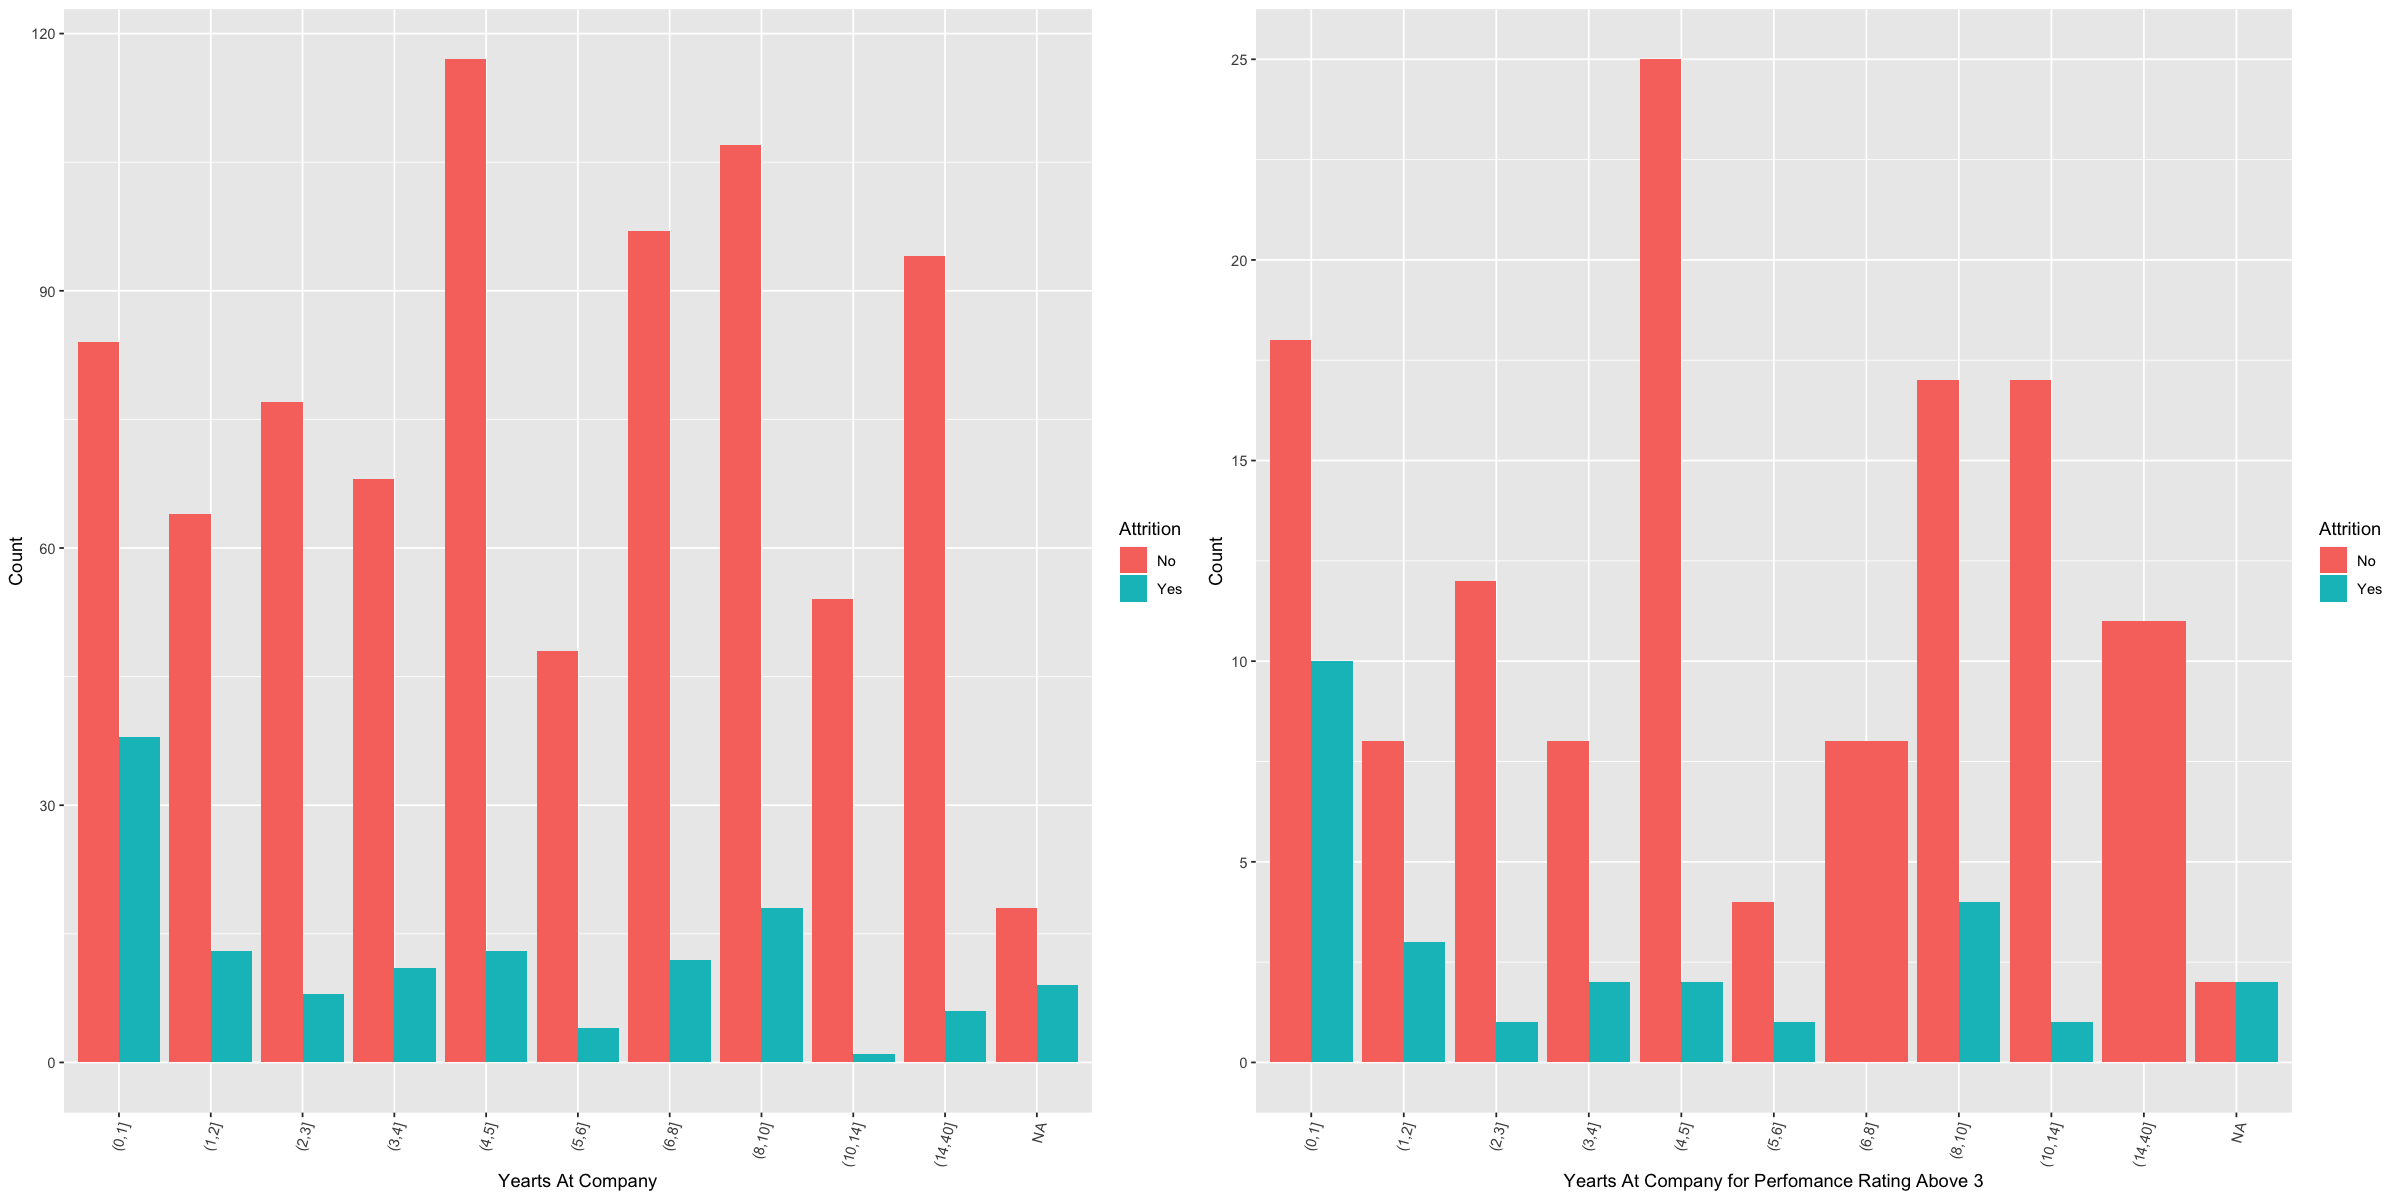

In [10]:
options(repr.plot.width=20, repr.plot.height=10)
p2 = ggplot(data = DF_RandD, 
            aes(x = Yrs_Comp_Bin,group = as.factor(Attrition),fill=as.factor(Attrition)))+
  geom_bar(stat="count", position=position_dodge())+
  labs(x = "Yearts At Company", y = "Count", fill = "Attrition")+
  theme(axis.text.x = element_text(angle = 75,hjust = 1))

p3 = ggplot(data = DF_RandD[which(DF_RandD$PerformanceRating>3),], 
            aes(x = Yrs_Comp_Bin,group = as.factor(Attrition),fill=as.factor(Attrition)))+
  geom_bar(stat="count", position=position_dodge())+
  labs(x = "Yearts At Company for Perfomance Rating Above 3", y = "Count", fill = "Attrition")+
  theme(axis.text.x = element_text(angle = 75,hjust = 1))

grid.arrange(p2,p3, ncol=2)

These graphs show the count of attrition and no attrition per bin of Years at The Company. Each bin has either a two or three year spam with the tails (14 and on) binned together. On the left side the graph shows the entire population of employees in the R&D department while on the right side only employees who have a performance rating above 3 are shown. Attrition is almost the same all throughout. In fact, the proportion of attrition is even higher for the first bin (0-1 years) who score higher than average (mean is 3) performance rating scores. It seems then that the conclusions made by the head of R&D don’t seem to be right. Lets dive deeper and look at a correlation table with all the factors involved in performance and years at the company.

###### Correlation Plots

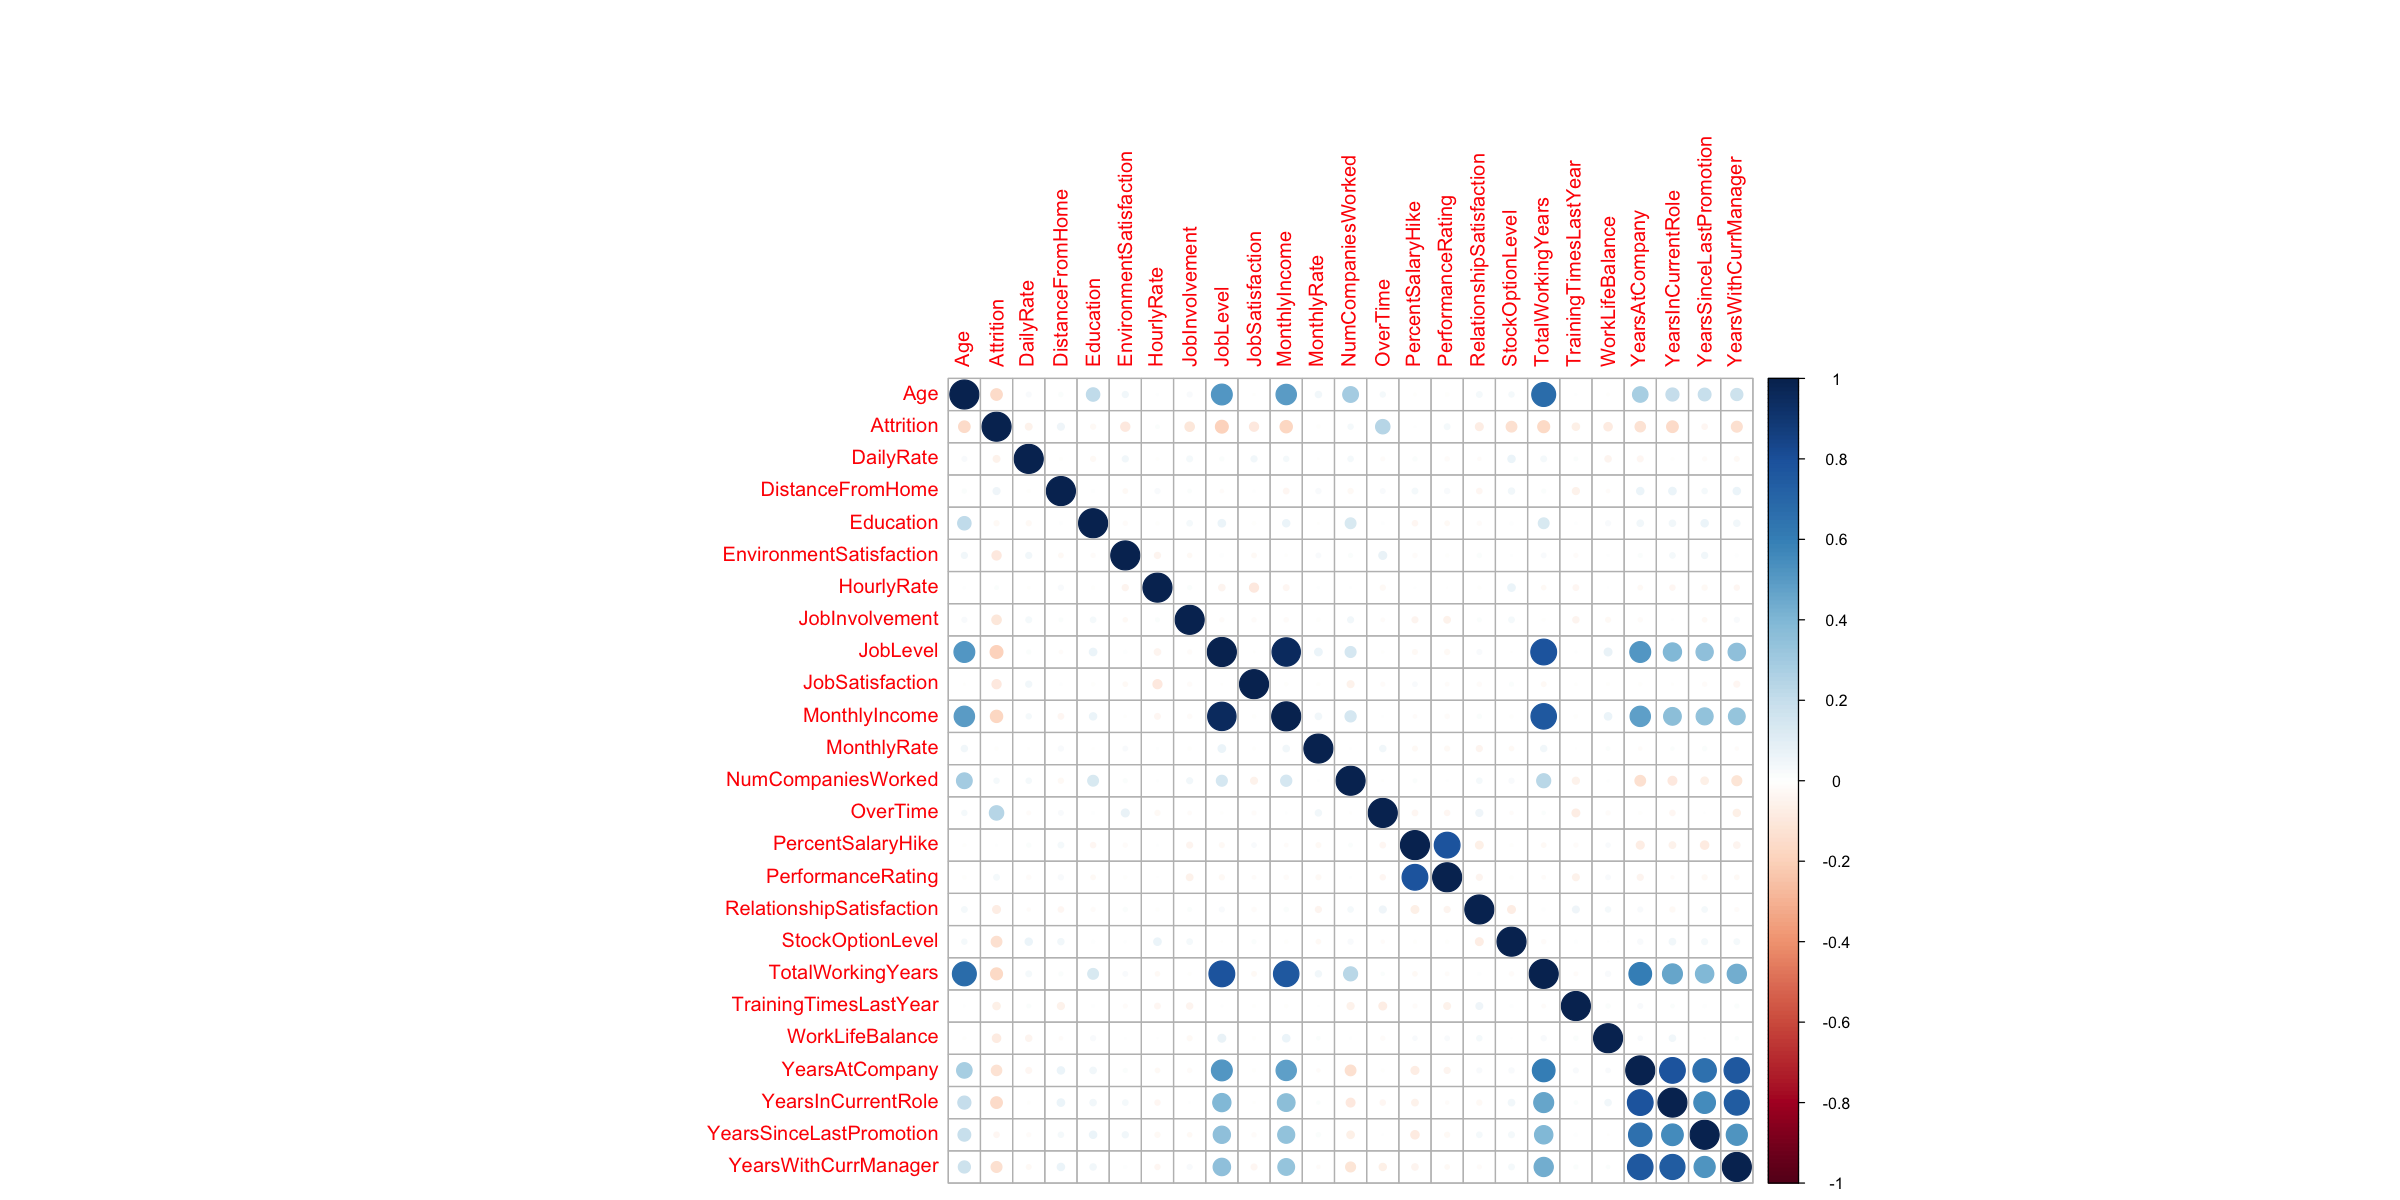

In [11]:
for_cor<-DF_RandD[,-c("EmployeeCount","EmployeeNumber","BusinessTravel","Department","EducationField","Gender",
                      "JobRole","MaritalStatus","Over18","StandardHours","Age_Bin", "Yrs_Comp_Bin")]
for_cor$OverTime<-ifelse(for_cor$OverTime == "Yes", yes =1,no=0)
for_cor$Attrition<-ifelse(for_cor$Attrition == "Yes", yes =1,no=0)
for_cor<-apply(for_cor,2,as.numeric)
corrplot(cor(for_cor))


It seems then that attrition is not highly correlated to any particular variable, however correlation doesn’t predict causation and therefore some more analysis is needed.

#### 4) Identify a subset of employees who are at disproportionate risk of leaving

In [12]:
#Prep Data for Modeling
model_set<-DF_RandD[,-c("Department","EmployeeCount","EmployeeNumber","StandardHours","Over18","Age",
                        "TotalWorkingYears","YearsAtCompany","YearsInCurrentRole","YearsSinceLastPromotion",
                        "YearsWithCurrManager","DailyRate","HourlyRate","MonthlyIncome","MonthlyRate")]
model_set$MonthlyRate_Bin<-as.character(SalaryM_DF$MonthlyRate_Bin)
model_set$MonthlyIncome_Bin = as.character(SalaryM_DF$MonthlyIncome_Bin)
model_set$Hourly_Bin = as.character(SalaryM_DF$Hourly_Bin)
model_set$Daily_Bin = as.character(SalaryM_DF$Daily_Bin)
model_set$Yrs_Comp_Bin<-as.character(model_set$Yrs_Comp_Bin)
model_set$Age_Bin<-as.character(model_set$Age_Bin)
as.data.frame(apply(apply(model_set,2,is.na),2,sum))

baseR.sbst.rssgn   <- function(x) { x[is.na(x)] <- "(0,0]"; x }
temp<-baseR.sbst.rssgn(model_set)

fctr.cols <- sapply(temp, is.character)
temp[, c(21:26)] <- as.data.frame(apply(temp[, c(21:26)],2, as.factor))
#str(temp)

#Splitting
ind = sample(2, nrow(temp), replace=TRUE, prob=c(0.7,0.3))
trainData = temp[ind==1,]
testData = temp[ind==2,]


,"apply(apply(model_set, 2, is.na), 2, sum)"
,<int>
Attrition,0
BusinessTravel,0
DistanceFromHome,0
Education,0
EducationField,0
EnvironmentSatisfaction,0
Gender,0
JobInvolvement,0
JobLevel,0


To understand the causal relationship between each variable and attrition I ran two statistical models; a random forest classifier and a logistic regression. Both models scored an accuracy of above 85% when predicting attrition based on the variables at hand. On the left side we can the intercept for each of the top variables is shown. This intercept tells us how each variable affects the result. So, for example, the furthest the distance the more likely it is that the person will leave the company (positive coefficient) but the highest the job involvement score is then it is less likely the person will leave the company (negative coefficient). 

In [13]:
#Fitting the Logistic Regression Model
fit_log<-glm(Attrition~., data=trainData,family = binomial)
sum_log<-as.data.frame(summary(fit_log)$coefficients)
sum_log[sum_log$`Pr(>|z|)`< 0.05,]

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


,Estimate,Std. Error,z value,Pr(>|z|)
,<dbl>,<dbl>,<dbl>,<dbl>
BusinessTravelTravel_Frequently,2.90215711,0.9129487,3.178883,1.478438e-03
BusinessTravelTravel_Rarely,1.67669134,0.8281620,2.024593,4.290914e-02
DistanceFromHome,0.05117937,0.0232649,2.199853,2.781733e-02
EducationFieldTechnical Degree,2.02917656,0.6804863,2.981951,2.864182e-03
EnvironmentSatisfaction,-0.67868345,0.1754823,-3.867532,1.099423e-04
GenderMale,0.97699962,0.4000734,2.442051,1.460409e-02
JobInvolvement,-0.59955314,0.2644374,-2.267278,2.337322e-02
JobSatisfaction,-0.52119740,0.1637329,-3.183218,1.456481e-03
OverTimeYes,2.43118184,0.4067991,5.976370,2.281641e-09


###### Variable Importance
Yet, the value of the intercept doesn’t really tell how important a specific variable is to the outcome of the model. In order to understand importance, we calculate an importance score for each variable and we get these results:

In [14]:
#Calculating Variable Importance for the Logistic Regression Model
var_i<-varImp(fit_log, scale = FALSE)
var_ii<-setDT(var_i, keep.rownames = TRUE)[]
var_ii<-as.data.frame(var_ii[order(var_i$Overall,decreasing = T),]  )

In [15]:
#Fitting the randomforest model
fit<-randomForest(Attrition~., data=trainData, ntree=500, proximity=T)
Pred = predict(fit, newdata=testData)
table(predict(fit), trainData$Attrition)
i_rf<-as.data.frame(importance(fit))
i_rf<-setDT(i_rf, keep.rownames = TRUE)[]
i_rf<-i_rf[order(i_rf$MeanDecreaseGini,decreasing = T),]

     
       No Yes
  No  578  79
  Yes   3  10

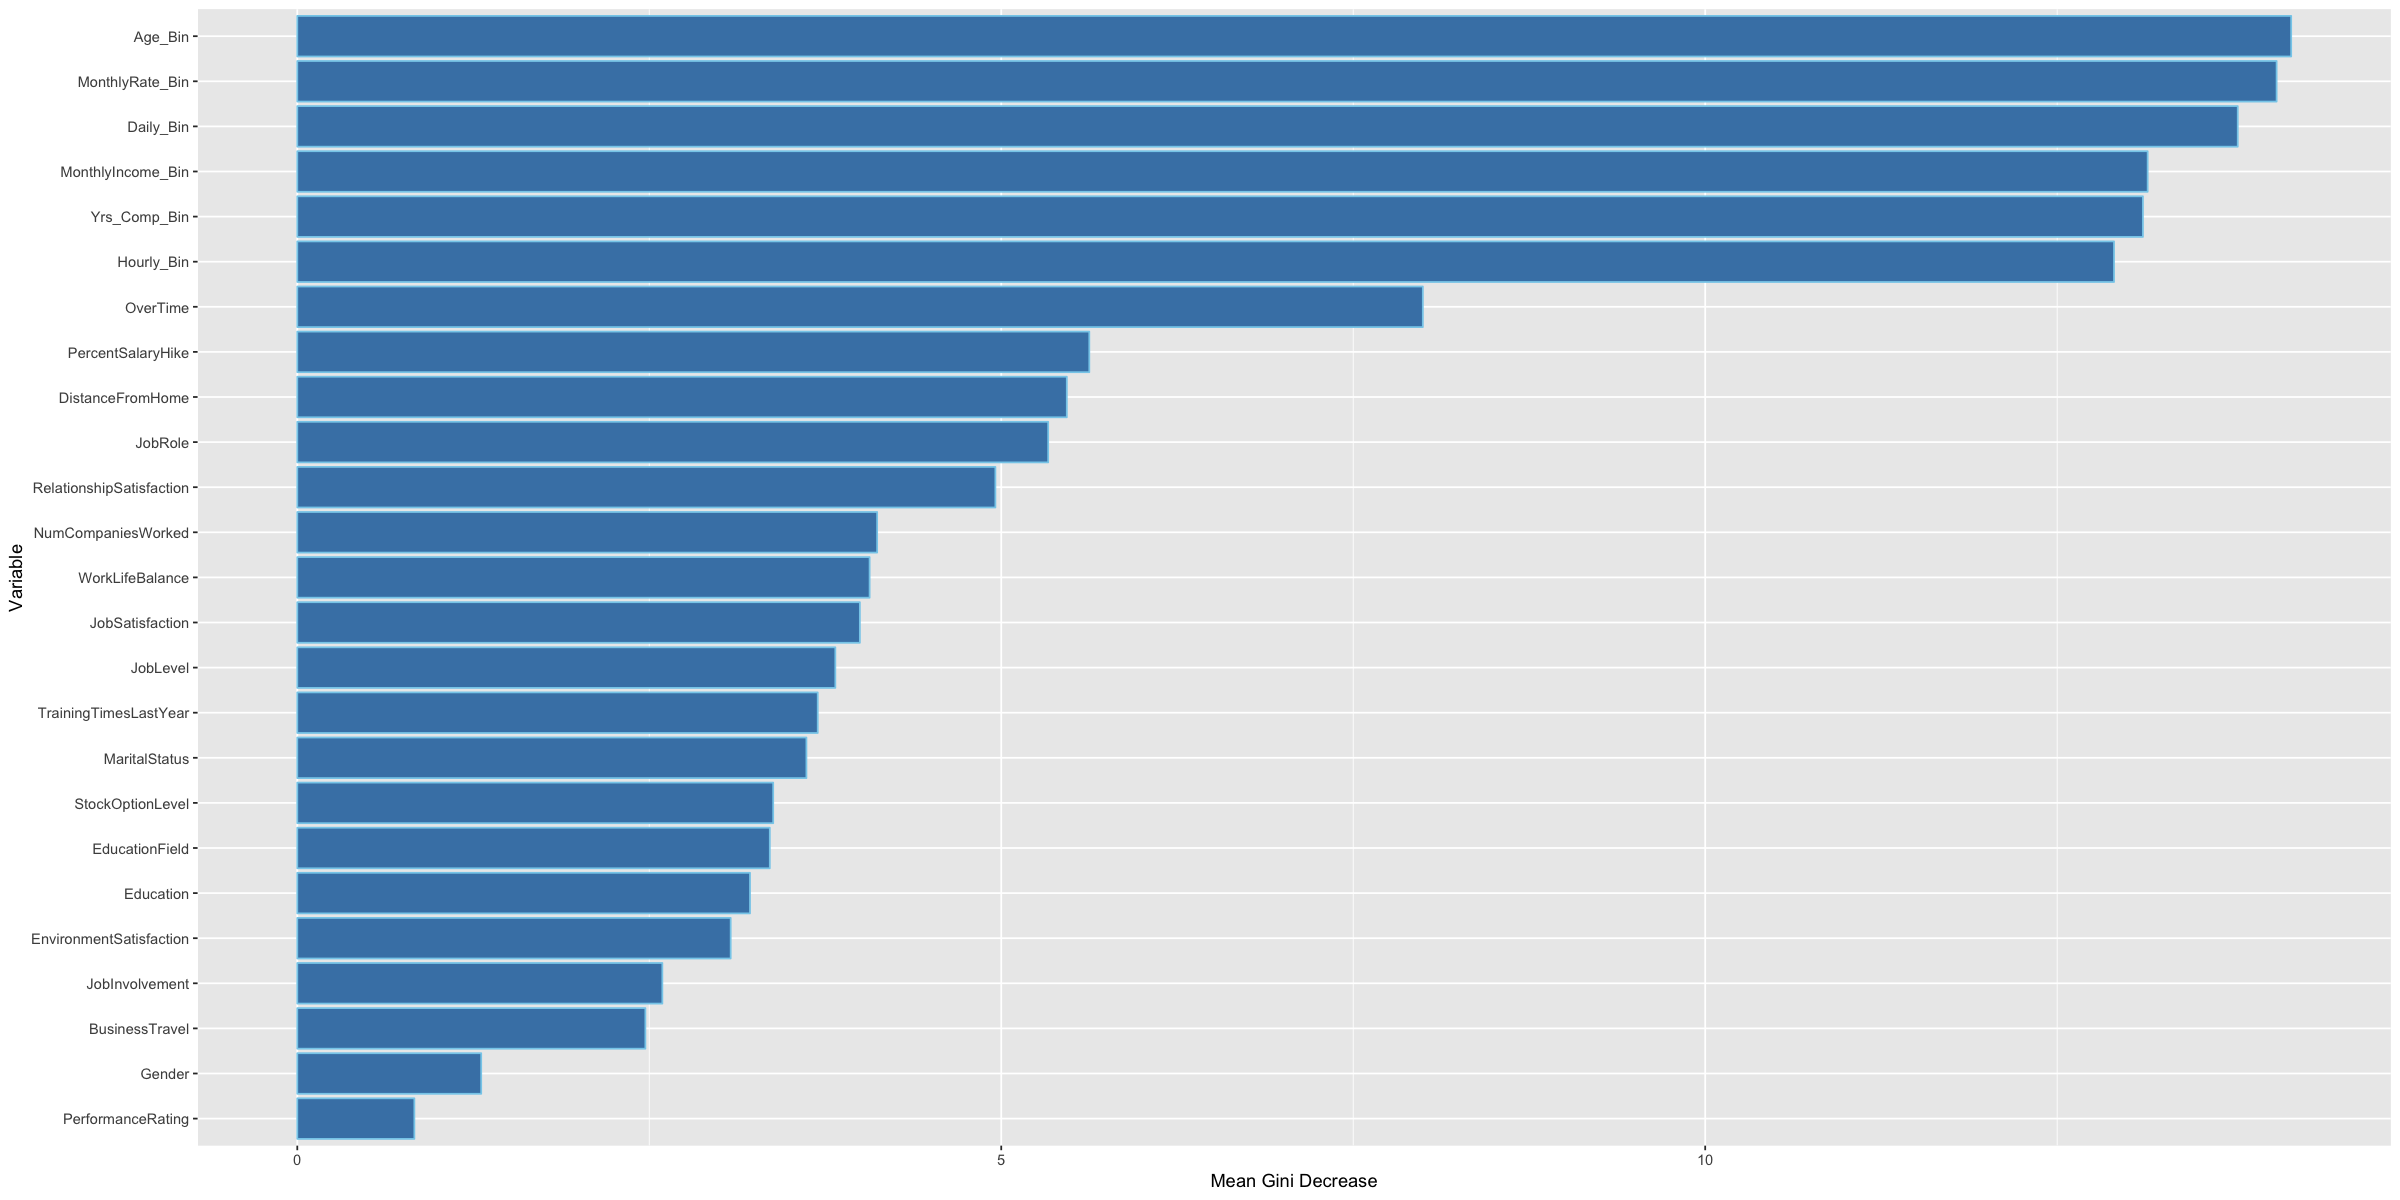

In [16]:
#Random Forest Tree Partition Variable Importance based on Mean Gini Decrease
ggplot(i_rf, aes(y=MeanDecreaseGini,x=reorder(rn,MeanDecreaseGini))) +
  geom_bar(stat='identity',color='skyblue',fill='steelblue') +
  labs(x = "Variable", y = "Mean Gini Decrease")+
  coord_flip()

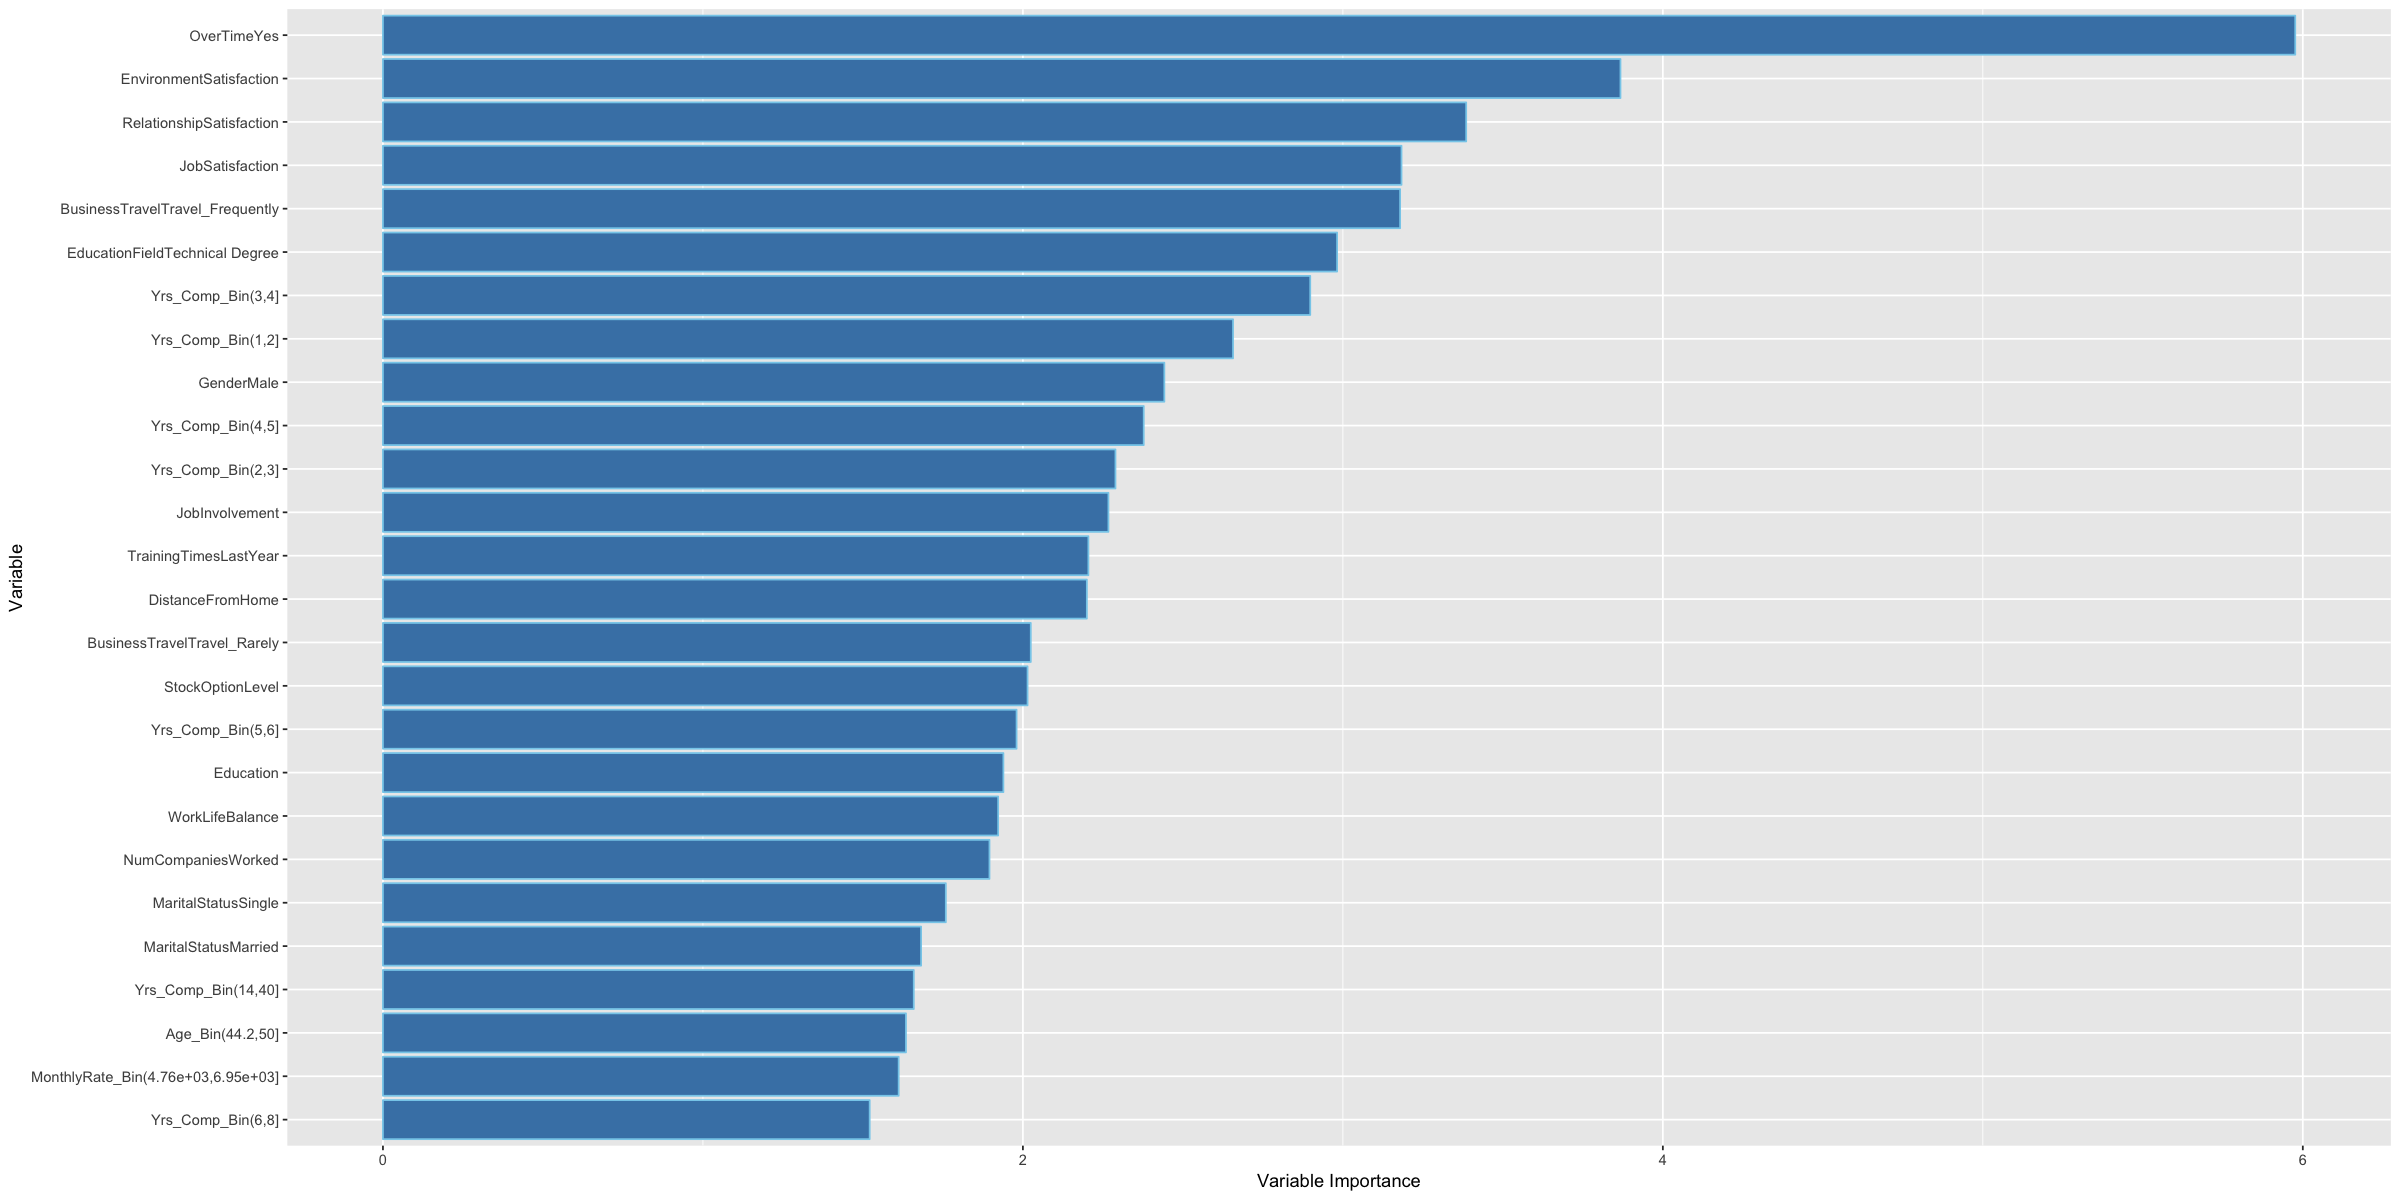

In [17]:
#Logistic Regression Variable importance measurement
ggplot(var_ii[var_ii$Overall>1.5,], aes(y=Overall,x=reorder(rn,Overall))) +
  geom_bar(stat='identity',color='skyblue',fill='steelblue') +
  labs(x = "Variable", y = "Variable Importance")+
  coord_flip()

In both of my models overtime and distance from home play a huge part in the importance of predicting attrition. If I were to create a subset of people who are the most likely to leave the company then I’d have to say that the employees who live the furthest away from work and work overtime are the most likely to leave. Business Travel Frequently also seems to impact the model a lot so it seems that being very far away from home is the deciding point for attrition. 
The model also confirms our theory and contradicts the argument made by the head of R&D; age does have an impact in the model but in a completely different way. Employee that fall on the bins of older employees (from 34-50) tend to not leave the company. In our model Age Bin (Ages binned into 10 categories of equal weight) is even a strong predictor, but a strong predictor for not leaving the company.
Another important aspect to point out is that employees with a technical degree tend to leave the company. Maybe the department does not require people to have such skillsets or these people are underpaid. For further analysis, a survey could be conducted on this subset of people to measure the likeliness of attrition.


#### 5) Recommendations for the head of R&D:

Base on my finds, if the head of R&D wants to retain its good employees then making them feel closer to home is the right way to go. Pay structures is also a good incentive but not always the deciding factor. Another important aspect to point out is that employees that travel a lot have the highest risk of attrition (based on its coefficient and variable importance measurement). A plan should be made so that employees that start out traveling frequently reduce their traveling as they get older. Far from home seems to be the deciding factor in this case and should be taken into consideration.

#### 6) Desingning a rapid Experiment to test out the Far From Home theory.

My theory is that employees that travel a lot are the most prone to leave the company at some point. So, in order to confirm my theory a survey of employees that have left the company could be conducted. The idea is to find out if they left for a position in another company that required less traveling. If the answer is positive then a more sophisticated experiment should be conducted where they measure attrition of employees who move towards jobs that requires less traveling versus employees who stay at jobs that require frequent traveling. Historical data on employee’s positions would need to be captured and stored and an evaluation over several years would be required. The selling point for this however, is that if you want to retain talent then you need to provide employees a framework where they feel closer to home as they get older. Here’s a brief overview of the statistics of the Only Travel Frequently Group vs the entire population:

In [18]:
#Entire population
summary(temp)


 Attrition           BusinessTravel DistanceFromHome   Education    
 No :828   Non-Travel       : 97    Min.   : 1.000   Min.   :1.000  
 Yes:133   Travel_Frequently:182    1st Qu.: 2.000   1st Qu.:2.000  
           Travel_Rarely    :682    Median : 7.000   Median :3.000  
                                    Mean   : 9.145   Mean   :2.899  
                                    3rd Qu.:14.000   3rd Qu.:4.000  
                                    Max.   :29.000   Max.   :5.000  
                                                                    
          EducationField EnvironmentSatisfaction    Gender    JobInvolvement 
 Human Resources :  0    Min.   :1.000           Female:379   Min.   :1.000  
 Life Sciences   :440    1st Qu.:2.000           Male  :582   1st Qu.:2.000  
 Marketing       :  0    Median :3.000                        Median :3.000  
 Medical         :363    Mean   :2.744                        Mean   :2.742  
 Other           : 64    3rd Qu.:4.000                    

In [19]:
#Only Travel Frequently
summary(temp[which(temp$BusinessTravel == "Travel_Frequently"),])

 Attrition           BusinessTravel DistanceFromHome   Education    
 No :145   Non-Travel       :  0    Min.   : 1.000   Min.   :1.000  
 Yes: 37   Travel_Frequently:182    1st Qu.: 2.000   1st Qu.:2.000  
           Travel_Rarely    :  0    Median : 7.000   Median :3.000  
                                    Mean   : 9.363   Mean   :2.874  
                                    3rd Qu.:15.000   3rd Qu.:4.000  
                                    Max.   :29.000   Max.   :5.000  
                                                                    
          EducationField EnvironmentSatisfaction    Gender    JobInvolvement 
 Human Resources : 0     Min.   :1.000           Female: 75   Min.   :1.000  
 Life Sciences   :91     1st Qu.:2.000           Male  :107   1st Qu.:2.000  
 Marketing       : 0     Median :3.000                        Median :3.000  
 Medical         :68     Mean   :2.709                        Mean   :2.747  
 Other           :10     3rd Qu.:4.000                    

As you can see from the statistics measurements, it seems that both cases share very similar characteristics. However, there are two key features to point out:              
- 20% of the employees that are registered as travel frequently have been labeled Yes for attrition while the rest of the population lies a little below the 14% mark.                  
- Attrition in general is very high in the 0-1 years working at the company and 18-26 Age range yet, there are no employees in those bins in the travel frequently subset. That means that more experienced employees are more likely to leave if they travel a lot.  
